# Face Recognition

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, this video shows a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

We're going to build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). For more references [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).


We aim to:

* Differentiate between face recognition and face verification
* Implement one-shot learning to solve a face recognition problem
* Apply the triplet loss function to learn a network's parameters in the context of face recognition
* Explain how to pose face recognition as a binary classification problem
* Map face images into 128-dimensional encodings using a pretrained model
* Perform face verification and face recognition with these encodings

**Channels-last notation**

We'll be using a pre-trained model which represents ConvNet activations using a "channels last" convention.

In other words, a batch of images will be of shape $(m, n_H, n_W, n_C)$. 

## Packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from PIL import Image
from numpy import asarray, savez_compressed
from os import listdir
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from keras_facenet import inception_resnet_v1
import numpy as np

In [2]:
def load_facenet():
    model = inception_resnet_v1.InceptionResNetV1(
        input_shape=(160, 160, 3),
        classes=128,
    )
    model.load_weights('keras-facenet-h5/model.h5')
    return model

In [3]:
model = load_facenet()
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'normalize')>]


In [4]:
def extract_image(image_path, detector: MTCNN):
    img = Image.open(image_path)
    img = img.convert('RGB')
    pixels = asarray(img)
    face = detector.detect_faces(pixels)
    
    # get the x, y, width, and hight of the face in the image
    x1, y1, w, h = face[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2 = x1 + w
    y2 = y1 + h
    
    # locate the face on the image
    store_face = pixels[y1:y2, x1:x2]
    plt.imshow(store_face)
    face_img = Image.fromarray(store_face, 'RGB')
    face_img = face_img.resize((160, 160)) # Resize so it can be used with FaceNet
    return asarray(face_img)
    

In [5]:
def load_faces(directory, detector):
    faces = []
    for filename in listdir(directory):
        file_path = directory + filename
        face = extract_image(file_path, detector)
        faces.append(face)
    return faces

In [6]:
def load_dataset(directory, detector):
    x, y = [], []
    for subdir in listdir(directory):
        path = directory + subdir +'/'
        faces = load_faces(path, detector)
        labels = [subdir for _ in range(len(faces))]
        print(f'There are {len(faces)} images in the class {subdir}')
        x.extend(faces)
        y.extend(labels)
    return asarray(x), asarray(y)

In [7]:
def extract_embedding(model, face_image):
    img = np.around(np.array(face_image) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [17]:
def who_is_it(image_path, database_vecs, database_labels, model, detector):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ## Step 1: Compute the target "encoding" for the image. Use 
    face_image = extract_image(image_path, detector)
    new_encoding =  extract_embedding(model, face_image)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 1000
    
    # Loop over the database dictionary's names and encodings.
    for encoding, name in zip(database_vecs, database_labels):
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(new_encoding - encoding, ord=2)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

1/1 [==============================] - 0s 206ms/step
There are 1 images in the class andrew
1/1 [==============================] - 0s 41ms/step
There are 1 images in the class arnaud
1/1 [==============================] - 0s 30ms/step
There are 1 images in the class benoit
1/1 [==============================] - 0s 29ms/step
There are 1 images in the class bertrand
1/1 [==============================] - 0s 40ms/step
There are 1 images in the class dan
1/1 [==============================] - 0s 40ms/step
There are 1 images in the class danielle
1/1 [==============================] - 0s 37ms/step
There are 1 images in the class felix
1/1 [==============================] - 0s 28ms/step
There are 1 images in the class kevin
1/1 [==============================] - 0s 26ms/step
There are 1 images in the class kian
1/1 [==============================] - 0s 30ms/step
There are 1 images in the class sebastiano
1/1 [==============================] - 0s 29ms/step
There are 1 images in the class tian

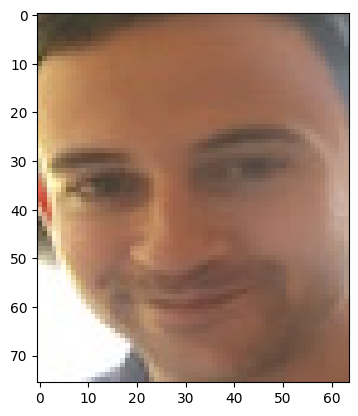

In [18]:
detector = MTCNN()
x, y = load_dataset('dataset/', detector)
database_vecs = []
for face in x:
    database_vecs .append(extract_embedding(model, face))
# plt.imshow(extract_image('images\\andrew.jpg',detector))

1/1 [==============================] - 0s 32ms/step
Not in the database.


(0.8188038, 'younes')

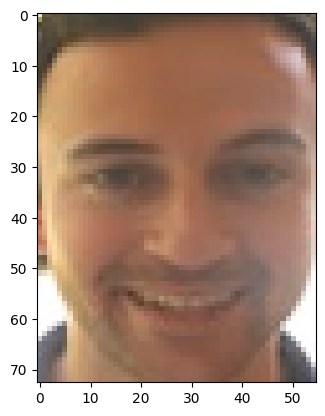

In [19]:
who_is_it('images\\camera_0.jpg', database_vecs, y, model, detector)

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 42ms/step
Not in the database.


(0.7280541, 'arnaud')

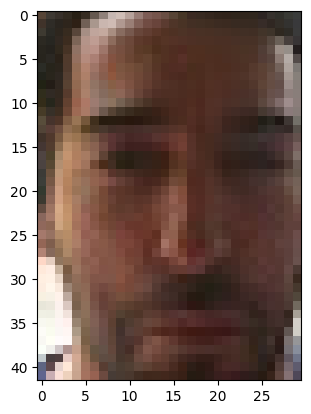

In [20]:
who_is_it('images\\camera_1.jpg', database_vecs, y, model, detector)


1/1 [==============================] - 0s 29ms/step
it's benoit, the distance is 0.15466371


(0.15466371, 'benoit')

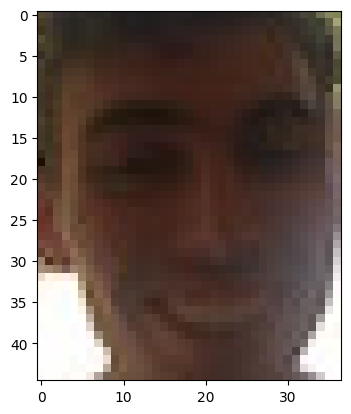

In [21]:
who_is_it('images\\camera_2.jpg', database_vecs, y, model, detector)


1/1 [==============================] - 0s 30ms/step
it's bertrand, the distance is 0.4823931


(0.4823931, 'bertrand')

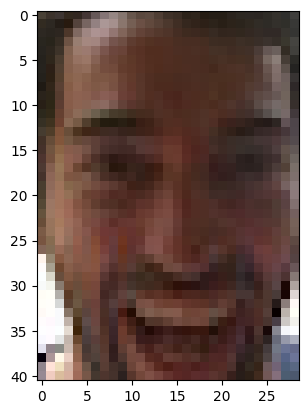

In [22]:
who_is_it('images\\camera_3.jpg', database_vecs, y, model, detector)


1/1 [==============================] - 0s 42ms/step
it's dan, the distance is 0.29466578


(0.29466578, 'dan')

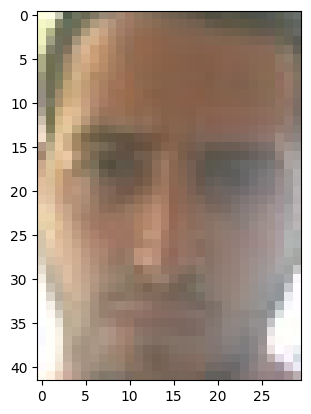

In [23]:
who_is_it('images\\camera_4.jpg', database_vecs, y, model, detector)


1/1 [==============================] - 0s 32ms/step
Not in the database.


(0.8066672, 'arnaud')

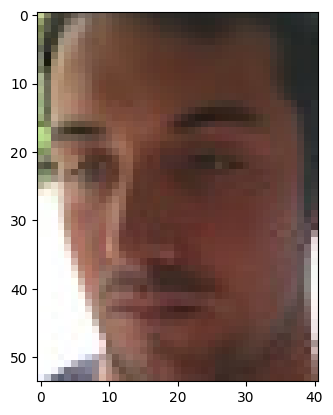

In [24]:
who_is_it('images\\camera_5.jpg', database_vecs, y, model, detector)


1/1 [==============================] - 0s 44ms/step
Not in the database.


(1.2380217, 'felix')

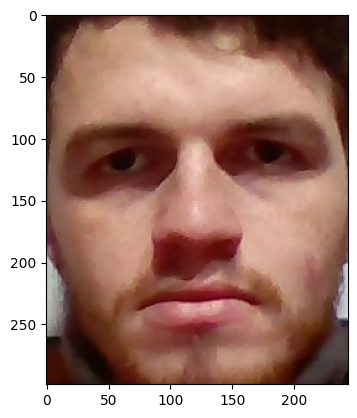

In [25]:
who_is_it('images\\haitham.jpg', database_vecs, y, model, detector)
